In [1]:
file = "https://drive.google.com/uc?id=18xM3jU2dSp1DiDqEM6PVXattNMZvsX4z"

In [2]:
!gdown {file}

Downloading...
From: https://drive.google.com/uc?id=18xM3jU2dSp1DiDqEM6PVXattNMZvsX4z
To: /home/ec2-user/SageMaker/repos/fastbook/experiments/Portrait.zip
100%|████████████████████████████████████████| 107M/107M [00:02<00:00, 50.3MB/s]


In [3]:
from zipfile import ZipFile

In [4]:
with ZipFile('Portrait.zip', 'r') as zip_ref:
  zip_ref.extractall('')

In [5]:
from fastai.vision.all import *

In [6]:
path = Path('')

In [7]:
lbl_names = get_image_files(path/'GT_png')
fnames = get_image_files(path/'images_data_crop')

In [8]:
img_fn = fnames[10]; img_fn

Path('images_data_crop/01208.jpg')

In [9]:
lbl_names[10]


Path('GT_png/00601_mask.png')

In [10]:
fn = '00013.jpg'

In [11]:
im = PILImage.create(f'images_data_crop/{fn}')

In [12]:
msk = PILMask.create(f'GT_png/00013_mask.png')

In [13]:
len(np.unique(msk))

2

In [14]:
np.unique(msk)

array([  0, 255], dtype=uint8)

In [15]:
def n_codes(fnames, is_partial=True):
  "Gather the codes from a list of `fnames`"
  vals = set()
  if is_partial:
    random.shuffle(fnames)
    fnames = fnames[:10]
  for fname in fnames:
    msk = np.array(PILMask.create(fname))
    for val in np.unique(msk):
      if val not in vals:
        vals.add(val)
  vals = list(vals)
  p2c = dict()
  for i,val in enumerate(vals):
    p2c[i] = vals[i]
  return p2c

In [16]:
p2c = n_codes(lbl_names)

In [17]:
p2c

{0: 0, 1: 255}

In [18]:
def get_msk(fn, p2c):
  "Grab a mask from a `filename` and adjust the pixels based on `pix2class`"
  fn = path/'GT_png'/f'{fn.stem}_mask.png'
  msk = np.array(PILMask.create(fn))
  mx = np.max(msk)
  for i, val in enumerate(p2c):
    msk[msk==p2c[i]] = val
  return PILMask.create(msk)

In [19]:
codes = ['Background', 'Face']


In [20]:
get_y = lambda o: get_msk(o, p2c)

In [21]:
binary = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=RandomSplitter(),
                   get_y=get_y,
                   item_tfms=Resize(224),
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)])

In [22]:
dls = binary.dataloaders(path/'images_data_crop', bs=8)


/home/ec2-user/anaconda3/envs/fastai/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


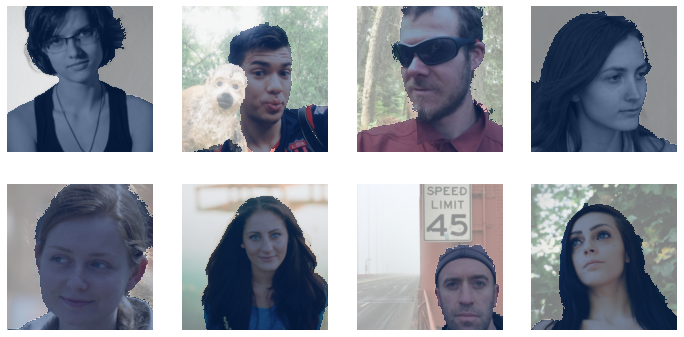

In [23]:
dls.show_batch(cmap='Blues', vmin=0, vmax=1)

In [24]:
learn = unet_learner(dls, resnet34)

In [25]:
learn.fit(1)

epoch,train_loss,valid_loss,time
0,0.386082,0.111686,02:11


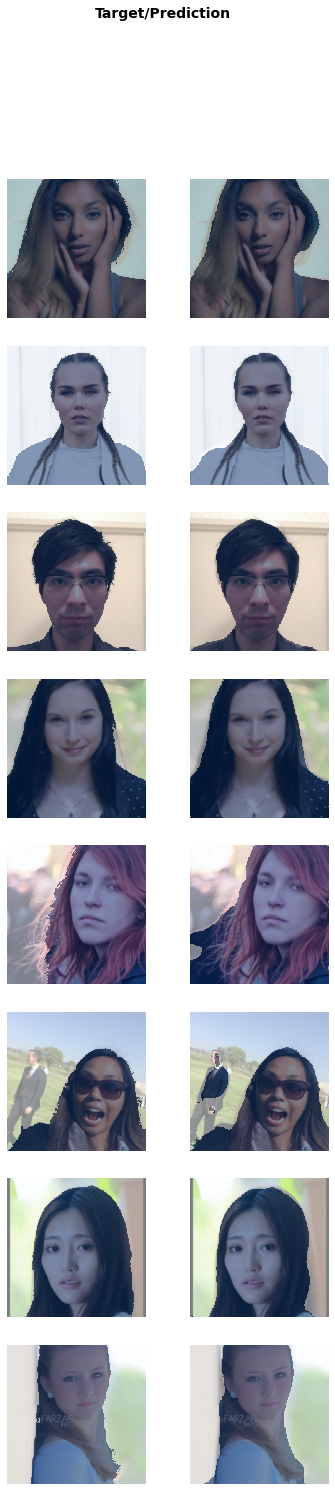

In [26]:
learn.show_results(cmap='Blues', vmin=0, vmax=1)

In [27]:
preds = learn.get_preds()

In [28]:
preds[0][0].shape

torch.Size([2, 224, 224])

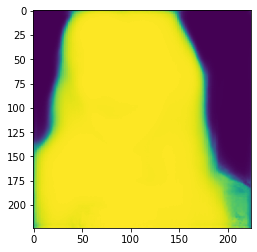

In [29]:
p = preds[0][0]
plt.imshow(p[1])

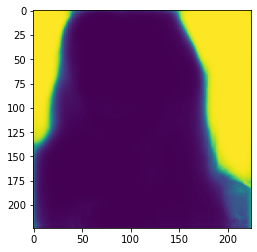

In [30]:
plt.imshow(p[0])